<a href="https://colab.research.google.com/github/ThiagoPoppe/snare_rythm_transcription/blob/main/projeto_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Instalando dependências para o projeto
!pip install git+https://github.com/ThiagoPoppe/snare_rythm_transcription.git

  Cloning https://github.com/ThiagoPoppe/snare_rythm_transcription.git to /tmp/pip-req-build-rh3n4l8t
  Running command git clone -q https://github.com/ThiagoPoppe/snare_rythm_transcription.git /tmp/pip-req-build-rh3n4l8t
  Created wheel for snare-rythm-transcription: filename=snare_rythm_transcription-0.1-py3-none-any.whl size=2633 sha256=09121a57c65b5cd099be1461b52f1526c10116ae576043d9339f4f6b1768b76d
  Stored in directory: /tmp/pip-ephem-wheel-cache-sso9yo5i/wheels/5f/61/77/1d6786fe6d5970ccc00d94354f82d1cacd18758b00c6dbc30e
Successfully built snare-rythm-transcription


# Configuração do ambiente (instalação de outras dependências)

In [2]:
import os
from music21.environment import UserSettings

# Musescore permite com que a gente renderize imagens com as notas musicas do music21
print('installing musescore...')
!apt-get install musescore > /dev/null

# FluidSynth será utilizado para converter midi para .wav (apenas para escutarmos)
print('installing fluidsynth...')
!apt-get install fluidsynth > /dev/null

# Configurações do virtual framebuffer (necessário para o Google Colab)
!apt-get install xvfb > /dev/null
!sh -e /etc/init.d/x11-common start > /dev/null

os.putenv('DISPLAY', ':99.0')
!start-stop-daemon --start --pidfile /var/run/xvfb.pid --make-pidfile --background --exec /usr/bin/Xvfb -- :99 -screen 0 1024x768x24 -ac +extension GLX +render -noreset

# Configurando o path do music21
us = UserSettings()
us['directoryScratch'] = '/tmp'
us['musicxmlPath'] = '/usr/bin/mscore'
us['musescoreDirectPNGPath'] = '/usr/bin/mscore'

print('done!')

installing musescore...
Extracting templates from packages: 100%
installing fluidsynth...
done!


# Unzip dos dados
- Para esse passo, certifique-se que você já incluiu o arquivo `archive.zip` do seguinte [link](https://drive.google.com/file/d/1UlRr061Fiy9kgxMSP_-9QqWN_RirAC7g/view?usp=sharing).

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Você pode realizar um mount do seu drive e dar unzip no arquivo
!unzip /content/drive/MyDrive/MIR/archive.zip -d /content/ > /dev/null

# Funções auxiliares

## 1) Funções de exibição

In [5]:
import os
import copy
import librosa
import IPython.display as ipd
from midi2audio import FluidSynth

def show(stream):
    """
        Método para exibir a partitura da música.

        Infelizmente o music21 ainda não suporta muitas features de instrumentos percussivos.
        Para isso, iremos modificar a nota apenas para a sua exibição correta.
        Por exemplo, um toque na caixa está na posição da nota B4 na partitura.

        Argumentos:
            - stream (Stream): música a ser exibida

        Retorno:
            - None

        Observações:
            - Infelizmente o music21 ainda não suporta muitas features de instrumentos percussivos.
              Para isso, iremos modificar a nota apenas para a sua exibição correta.
              Por exemplo, um toque na caixa está na posição da nota B4 na partitura.
    """
    stream_cp = copy.deepcopy(stream)
    for note in stream_cp.recurse().notes:
        note.name = 'B4' # toques na caixa correspondem à posição do B4
        note.stemDirection = 'up'

    stream_cp.show()

def play(stream, wavname='music.wav', sound_font='pns_drum_kit.SF2'):
    """
        Método para tocarmos a música.

        Argumentos:
            - stream (Stream): música a ser exibida
            - wavname: nome do .wav a ser gerado (default = 'music.wav')
            - sound_font: sound font a ser utilizado (default = 'pns_drum_kit.SF2')

        Retorno:
            - None

        Observações:
            - Como estamos trabalhando exclusivamente com percussão, utilizaremos
              por padrão um SoundFont de bateria.
    """
    if not os.path.exists(sound_font):
        raise ValueError(f'sound font {sound_font} not found')

    midi_file = stream.write('midi')
    fs = FluidSynth(sound_font=sound_font)
    fs.midi_to_audio(midi_file, wavname)

    wave, sr = librosa.load(wavname, sr=None)
    ipd.display(ipd.Audio(wave, rate=sr))

## 2) Funções de partitura

In [6]:
from music21.note import Note
from music21.stream import Stream
from music21.clef import PercussionClef
from music21.tempo import MetronomeMark
from music21.meter import TimeSignature

def snare_hit(midi=38, time_figure=1.0):
    """
        Método auxiliar para criarmos um toque na caixa.

        Argumentos:
            - midi (int): valor em MIDI da "nota" (default = 38)
            - time_figure (float): figura de tempo da nota, utilizando a semínima como referência (default = 1.0)

        Retorno:
            - Esse método retorna um Note do music21 representando um toque na caixa.
    """
    return Note(midi, quarterLength=time_figure)

def create_percussive_stream(bpm=60, time_signature='4/4'):
    """
        Método auxiliar para criarmos um stream percussivo.

        Argumentos:
            - bpm (int): BPM da música (default = 60)
            - time_signature (str): fórmula de compasso da música (default = '4/4')

        Retorno:
            - Um Stream com o BPM e TimeSignature informados.
    """
    stream = Stream()
    stream.insert(0, PercussionClef())
    stream.insert(0, MetronomeMark(number=bpm))
    stream.insert(0, TimeSignature(time_signature))

    return stream

## 3) Funções de transcrição

In [7]:
import librosa
import numpy as np
from music21.note import Rest

def estimate_tempo(wave, sr, **kwargs):
    """
        Método para estimar o tempo (BPM) da música utilizando a função
        beat.tempo da biblioteca librosa.
    
        Argumentos:
            - wave (np.array): música na representação vetorial
            - sr (int): taxa de amostragem da música
            - kwargs: outros argumentos para a função librosa.beat.tempo

        Retorno:
            - O valor inteiro do BPM (batidas por minuto).
    """
    tempo = librosa.beat.tempo(wave, sr, **kwargs)
    return int(np.round(tempo))

def estimate_snare_hit_times(wave, sr):
    """
        Método para estimar as batidas da caixa utilizando a função onset.onset_detect
        da biblioteca librosa.

        Argumentos:
            - wave (np.array): música na representação vetorial
            - sr (int): taxa de amostragem da música

        Retorno:
            - Tempos, em segundos, em que ocorrem batidas na caixa.
    """

    # Criando uma modificação da música com 1 segundo de silêncio no começo
    wave_mod = np.zeros(len(wave) + sr)
    wave_mod[sr:] = wave

    # Estimando as batidas da música (agora devemos subtrair 1 segundo do vetor)
    snare_times = librosa.onset.onset_detect(wave_mod, sr, units='time') - 1.0
    # return np.round(snare_times, decimals=2)
    return snare_times

def create_metronome(tempo=60, duration=60, reference_note=4):
    """
        Método para criarmos um metrônomo seguindo um BPM fornecido.

        Argumentos:
            - tempo (int): batimentos por minuto do metrônomo
            - duration (int): duração em segundos do metrônomo
            - reference_note (int): nota de referência (denominador) da figura de tempo.

        Retorno:
            - Um np.array indicando as batidas do metrônomo em segundos.
    """

    # Verificando se a nota de referência é uma potência de 2
    log = np.log2(reference_note)
    if np.floor(log) != np.ceil(log):
        raise ValueError('the reference note must be a power of 2')

    # Definindo o tempo de passo de uma batida para a próxima
    # Basta dividirmos 60 segundos por bpm e subdividir isso de acordo com a nota de referência
    step = (60 / tempo) / (reference_note / 4)
    return np.arange(0, duration, step)

def extract_measures(snare_times, metronome, notes_per_measure):
    """
        Método para extrair as notas de cada compasso.

        Argumentos:
            - snare_times (np.array): os tempos, em segundos, em que ocorrem batidas na caixa
            - metronome (np.array): os tempos, em segundos, em que ocorrem as batidas do metrônomo
            - notes_per_measure (int): numerador da fórmula de compasso, indicando quantas notas há em cada compasso
    
        Retorno:
            - Uma lista representando os compassos da música. Cada posição terá uma outra lista com os tempos em que
              ocorrem as batidas da caixa dentro daquele compasso.
    """

    measures = []
    for i in range(0, len(metronome), notes_per_measure):
        min_t = metronome[i]
        max_t = metronome[i + notes_per_measure]

        # Verificando se já chegamos no final da música
        if min_t > snare_times[-1]:
            break

        # Filtrando os tempos da caixa que estão dentro dos limites do compasso
        mask = (snare_times >= min_t) & (snare_times < max_t)
        measures.append(snare_times[mask])

    return measures

def find_best_time_figure(dt, reference_note, reference_note_duration):
    """
        Método auxiliar para determinar a melhor figura de tempo de uma nota.

        Argumentos:
            - dt (float): diferença de tempo entre as notas.
            - reference_note (int): nota de referência da fórmula de compasso (denominador)
            - reference_note_duration (float): duração, em segundos, da nota de referência
    
        Retorno:
            - A figura de tempo da nota no formato fracionário utilizando a semínima como referência.
              Por exemplo: a semínima terá valor 1 enquanto que uma colcheia terá valor 1/2.
    """

    figure = None
    best_match = np.inf
    
    # Para cada subdivisão iremos verificar qual possui o tempo mais próximo
    for subdiv in [4, 2, 1, 1/2, 1/4]:
        # Verificando com a subdivisão original
        dur = subdiv * reference_note_duration
        if np.abs(dt - dur) < best_match:
            best_match = np.abs(dt - dur)
            figure = subdiv / (reference_note / 4) # precisamos corrigir a subdivisão baseado na figura de tempo

        # Verificando com a subdivisão em tercina (só faz "sentido" em subdivisão binária)
        if reference_note == 4:
            triplet = subdiv / 3
            dur = triplet * reference_note_duration
            if np.abs(dt - dur) < best_match:
                best_match = np.abs(dt - dur)
                figure = triplet

        # Verificando com a subdivisão com ponto (+ 1/2 do tempo)
        dotted = subdiv + (0.5 * subdiv)
        dur = dotted * reference_note_duration
        if np.abs(dt - dur) < best_match:
            best_match = np.abs(dt - dur)
            figure = dotted / (reference_note / 4) # precisamos corrigir a subdivisão baseado na figura de tempo

    return figure

def transcribe(snare_times, metronome, time_signature='4/4'):
    """
        Método para transcrever o ritmo da caixa da bateria.

        Argumentos:
            - snare_times (np.array): os tempos, em segundos, em que ocorrem batidas na caixa
            - metronome (np.array): os tempos, em segundos, em que ocorrem as batidas do metrônomo
            - time_signature (str): fórmula de compasso da música, por exemplo "4/4".

        Retorno:
            - Lista com "notas" (tanto notas como pausas) do music21. Note que a figura de tempo de cada "nota"
              estará no formato fracionário utilizando a semínima como referência. Por exemplo: a semínima terá
              valor 1 enquanto que uma colcheia terá valor 1/2.
    """

    reference_note_duration = metronome[1] - metronome[0]
    notes_per_measure, reference_note = tuple(map(int, time_signature.split('/')))

    # Computando o limite de notas de referência por compasso
    acc_time_figure = 0.0
    measure_time_figure_limit = notes_per_measure * (4 / reference_note)

    notes = []
    for i, dt in enumerate(np.diff(snare_times)):
        figure = find_best_time_figure(dt, reference_note, reference_note_duration)

        # Verificando se a figura de tempo ultrapassa o limite do compasso
        # Se sim, iremos criar uma nota com o tempo igual ao tempo restante do compasso e pausas
        # para preencher o restante do tempo
        total = np.round(acc_time_figure + figure, decimals=2)
        # total = acc_time_figure + figure
        if total > measure_time_figure_limit:
            note_figure = measure_time_figure_limit - acc_time_figure
            rest_figure = figure - note_figure

            notes.append(snare_hit(time_figure=note_figure))
            notes.append(Rest(quarterLength=rest_figure))
            acc_time_figure = rest_figure # o próximo compasso já foi preenchido pela figura da pausa

        # Senão, podemos apenas inserir uma nota com essa figura de tempo
        else:
            notes.append(snare_hit(time_figure=figure))
            acc_time_figure += figure
            if np.isclose(acc_time_figure, measure_time_figure_limit, rtol=1e-4):
                acc_time_figure = 0.0

    # Devido ao uso do np.diff, não conseguimos encontrar a figura de tempo da última nota com o loop de cima.
    # Mas é simples, a última nota terá como figura de tempo o tempo restante do compasso
    note_figure = measure_time_figure_limit - acc_time_figure
    notes.append(snare_hit(time_figure=note_figure))

    return notes

def transcription_pipeline(wavname, sr=None, tempo=None, time_signature='4/4'):
    """
        Método para transcrever o ritmo da caixa da bateria de um áudio.

        Argumentos:
            - wavname (str): caminho para o arquivo .wav
            - sr (int): taxa de amostragem da música (None -> irá utilizar a taxa original)
            - tempo (int): batidas por minuto da música (None -> irá estimar esse valor)
            - time_signature (str): fórmula de compasso da música, por exemplo "4/4"

        Retorno:
            - Uma Stream do music21 representando a partitura da música transcrita.
    """

    wave, sr = librosa.load(wavname, sr=sr)
    if tempo is None:
        tempo = estimate_tempo(wave, sr, aggregate=np.median)
    
    snare_times = estimate_snare_hit_times(wave, sr)
    notes_per_measure, reference_note = tuple(map(int, time_signature.split('/')))
    metronome = create_metronome(tempo=tempo, reference_note=reference_note)

    stream = create_percussive_stream(tempo, time_signature)
    for note in transcribe(snare_times, metronome, time_signature):
        stream.append(note)

    return stream

# Exemplo para vermos se está tudo funcional
- Para esse exemplo, você deveria ser capaz de observar uma partitura de percussão (iniciada com duas barrinhas), com fórmula de compasso 4/4 e BPM = 80. Além disso, deveria ser capaz de ver 6 notas, sendo elas 1 tercina (triplet) e 3 semínimas.

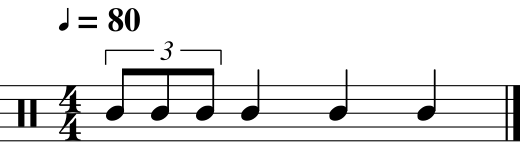

In [8]:
stream = create_percussive_stream(bpm=80, time_signature='4/4')
stream.repeatAppend(snare_hit(time_figure=1/3), 3)
stream.repeatAppend(snare_hit(), 3)

play(stream)
show(stream)

# Processo de transcrição para uma música qualquer

## Passo 0) Escolhendo uma música para aplicarmos as ideias

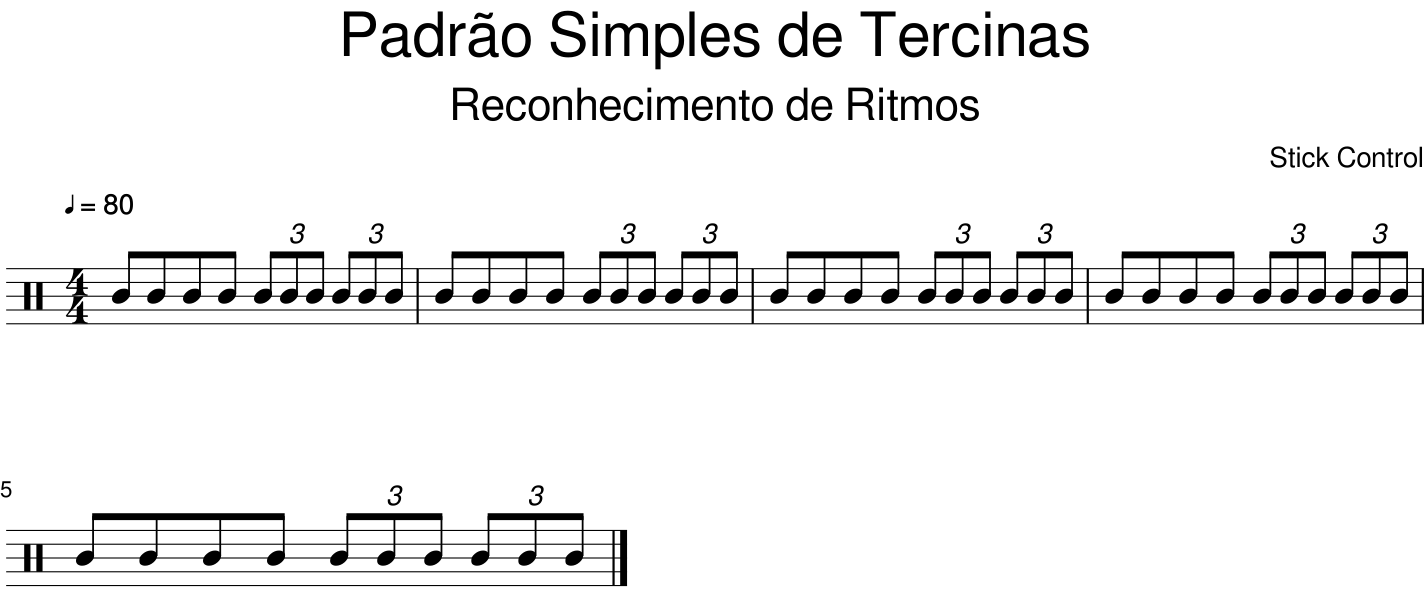

In [9]:
import IPython.display as ipd
from music21.converter import parse

wavname = 'data/audios/stick_control/padrao_simples_de_tercinas.wav'
xml_name = 'data/xmls/stick_control/padrao_simples_de_tercinas.musicxml'

play(parse(xml_name))
show(parse(xml_name))

## Passo 1) Identificar o BPM da música
- Para identificar o BPM (batimentos por minuto) da música, usaremos a função `beat.tempo` presente na biblioteca `librosa`.

In [10]:
import librosa
import numpy as np

# Carregando a música com librosa
wave, sr = librosa.load(wavname, sr=None)
song_length = np.round(len(wave) / sr, decimals=2)

print(f'Taxa de amostragem: {sr}')
print(f'Tempo aproximado da música: {song_length} segundos')

Taxa de amostragem: 44100
Tempo aproximado da música: 16.96 segundos


In [11]:
# Estimando o BPM da música escolhida
tempo = estimate_tempo(wave, sr)
print('BPM estimado:', tempo)

BPM estimado: 120


- Perceba que estimamos um valor de BPM igual à 120, ou seja 40 unidades a mais do que o valor real. Para melhorar a resposta, podemos ajustar os parâmetros passados para a função como podemos ver a seguir.

In [12]:
# Estimando o BPM (com ajuste de parâmetros)
tempo = estimate_tempo(wave, sr, aggregate=np.median)
print('BPM estimado:', tempo)

BPM estimado: 80


- Note que agora, utilizando `aggregate = np.median`, ao invés do valor padrão (média), temos o valor correto.

## Passo 2) Reconhecer o tempo das batidas da caixa

- Como estamos trabalhando apenas com um único instrumento percussivo (caixa), podemos utilizar o método `onset.onset_detect` da biblioteca `librosa` para identificar eventos [onset](https://en.wikipedia.org/wiki/Onset_(audio)).

Encontramos 50 batidas na caixa


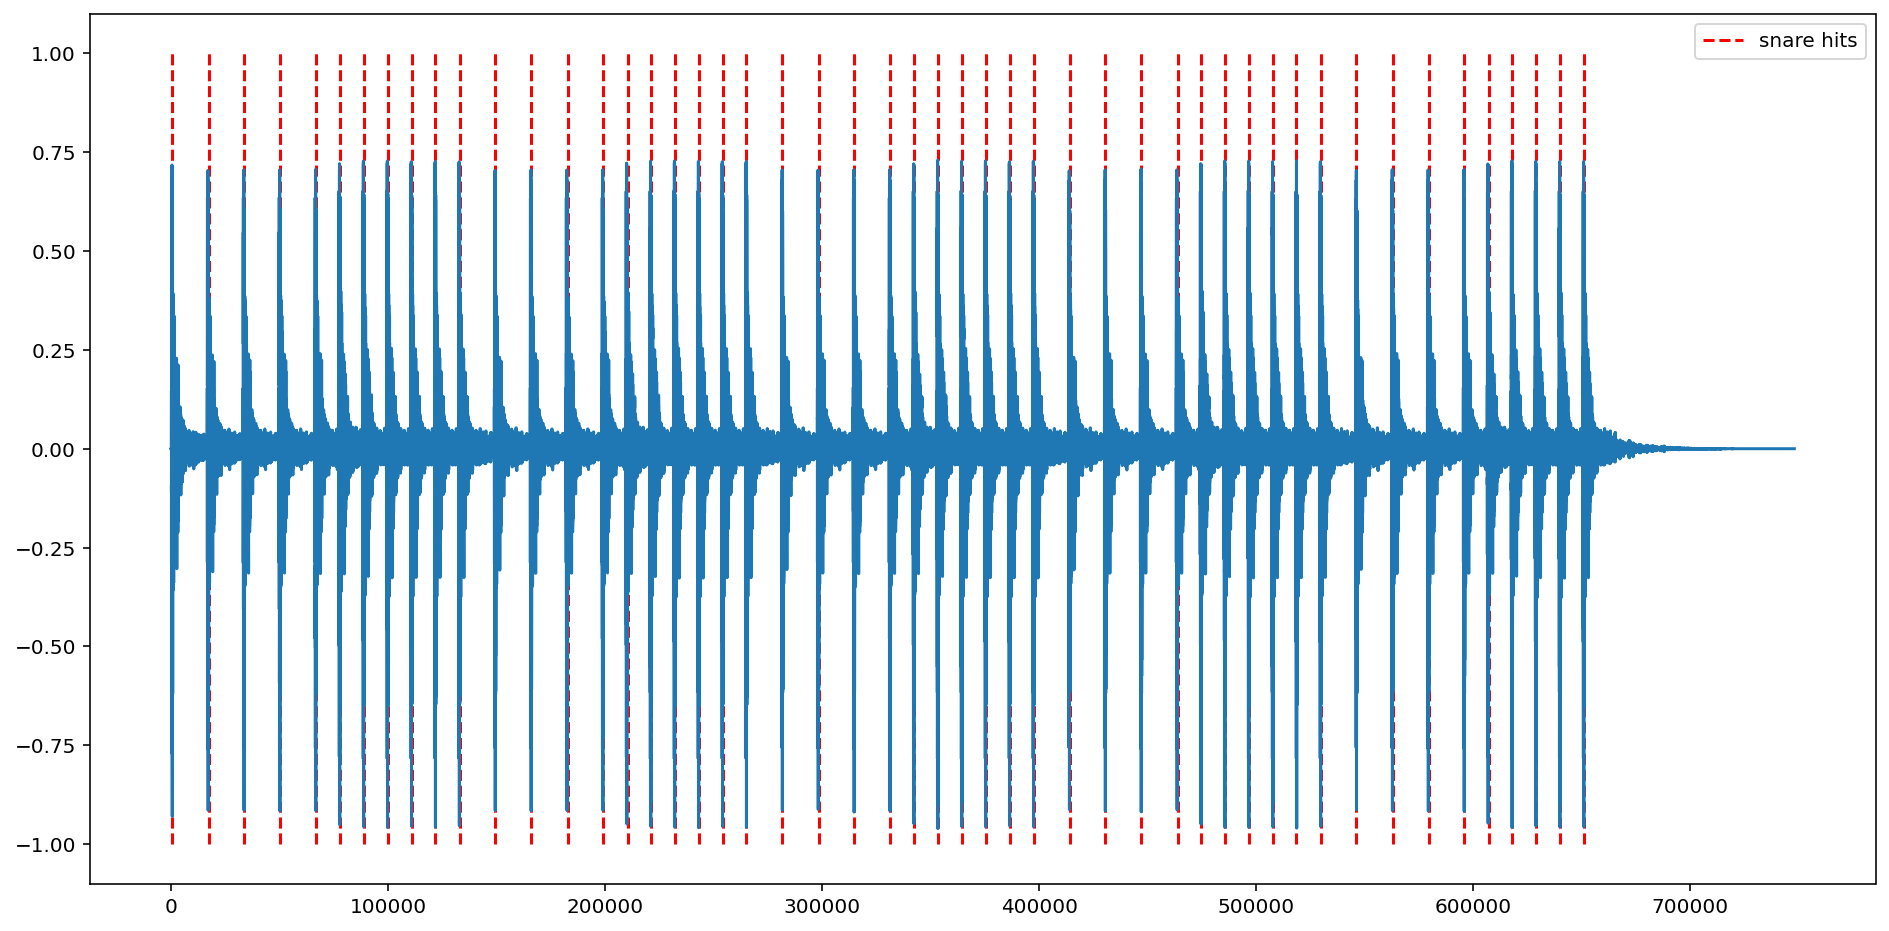

In [13]:
import librosa.display
import matplotlib.pyplot as plt

# Estimando as batidas da música
snare_times = estimate_snare_hit_times(wave, sr)
print(f'Encontramos {len(snare_times)} batidas na caixa')

# Analisando se conseguimos capturar as batidas de forma precisa
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(wave)
snare_samples = librosa.time_to_samples(snare_times, sr=sr)
ax.vlines(x=snare_samples, ymin=-1, ymax=1, linestyle='--', color='red', label='snare hits')
ax.legend(loc='upper right')

In [14]:
print('Batidas na caixa em samples:', snare_samples)
print('\nBatidas na caixa em segundos:', snare_times)

Batidas na caixa em samples: [   444  17339  33724  50107  67004  77756  89020  99771 111036 121787
 133052 149436 165820 182716 199100 210364 221116 232380 243132 254396
 265148 281532 298428 314812 331196 342459 353212 364476 375740 386492
 397756 414140 430524 446908 463804 474556 485820 496572 507836 518588
 529852 546236 563132 579516 595900 607164 617916 629180 639932 651196]

Batidas na caixa em segundos: [1.00680272e-02 3.93197279e-01 7.64716553e-01 1.13623583e+00
 1.51936508e+00 1.76317460e+00 2.01859410e+00 2.26240363e+00
 2.51782313e+00 2.76163265e+00 3.01705215e+00 3.38857143e+00
 3.76009070e+00 4.14321995e+00 4.51473923e+00 4.77015873e+00
 5.01396825e+00 5.26938776e+00 5.51319728e+00 5.76861678e+00
 6.01242630e+00 6.38394558e+00 6.76707483e+00 7.13859410e+00
 7.51011338e+00 7.76553288e+00 8.00934240e+00 8.26476190e+00
 8.52018141e+00 8.76399093e+00 9.01941043e+00 9.39092971e+00
 9.76244898e+00 1.01339683e+01 1.05170975e+01 1.07609070e+01
 1.10163265e+01 1.12601361e+01 1.15

## Passo 3) Criação de um metrônomo

- Iremos criar um [metrônomo](https://pt.wikipedia.org/wiki/Metr%C3%B4nomo) seguindo o BPM estimado no passo anterior. Um metrônomo possui as batidas espaçadas de forma igualitária de acordo com uma [fórmula de compasso](https://blog.landr.com/pt-br/formulas-de-compasso-como-sentir-a-batida/#:~:text=A%20f%C3%B3rmula%20de%20compasso%20%C3%A9%20um%20s%C3%ADmbolo%20de%20dois%20n%C3%BAmeros,batidas%20em%20cada%20compasso%20musical), mais especificamente de acordo com o denominador (figura de tempo de referência) da fórmula.

    - Para esse projeto, a fórmula de compasso será informada na entrada do problema.

In [15]:
time_signature = '4/4'
notes_per_measure, reference_note = tuple(map(int, time_signature.split('/')))

metronome = create_metronome(tempo=tempo, reference_note=reference_note)
clicks = librosa.clicks(times=metronome, length=len(wave), sr=sr)

# Ouvindo a música + metrônomo
ipd.display(ipd.Audio(clicks + wave, rate=sr))

## Passo 04) Divindo a música em compassos (talvez não precise, o music21 se vira)

- Para começarmos o processo de transcrição, precisamos primeiro determinar as notas que participam de cada compasso da música. Para isso, usaremos o metrônomo como referência. Por exemplo, se temos uma fórmula de compasso 4/4, sabemos que: a cada 4 batidas do metrônomo teremos 1 compasso.

In [16]:
measures = extract_measures(snare_times, metronome, notes_per_measure)
for idx, measure in enumerate(measures):
    print(f'Compasso {idx+1} possui {len(measure)} notas: {measure}')

Compasso 1 possui 10 notas: [0.01006803 0.39319728 0.76471655 1.13623583 1.51936508 1.7631746
 2.0185941  2.26240363 2.51782313 2.76163265]
Compasso 2 possui 10 notas: [3.01705215 3.38857143 3.7600907  4.14321995 4.51473923 4.77015873
 5.01396825 5.26938776 5.51319728 5.76861678]
Compasso 3 possui 10 notas: [6.0124263  6.38394558 6.76707483 7.1385941  7.51011338 7.76553288
 8.0093424  8.2647619  8.52018141 8.76399093]
Compasso 4 possui 10 notas: [ 9.01941043  9.39092971  9.76244898 10.13396825 10.51709751 10.76090703
 11.01632653 11.26013605 11.51555556 11.75936508]
Compasso 5 possui 10 notas: [12.01478458 12.38630385 12.76943311 13.14095238 13.51247166 13.76789116
 14.01170068 14.26712018 14.51092971 14.76634921]


- Podemos perceber acima que conseguimos dividir os 5 compassos da música de forma perfeita, mas podem ter casos onde isso não irá ocorrer com tanta perfeição (ainda mais em compassos complexos ou compostos).

## Passo 05) Determinando a figura de tempo de cada nota

- Para determinar a figura de tempo de cada nota, iremos olhar para a diferença de tempo de cada uma delas. No caso de uma música com BPM = 80 e fórmula de compasso 4/4, teremos que a duração de uma semínima será 0.75 segundos.

- Sabendo que, para esse contexto, a duração de uma semínima é de 0.75 segundos, conseguimos dividir esse valor por 2 para encontrar o tempo de uma colcheia, ou multiplicar por 2 para encontrar o tempo de uma mínima, por exemplo.

- Para cada diferença do tempo das notas, iremos ver qual valor mais se aproxima da subdivisão do tempo de uma semínima determinado pelo metrônomo.

In [17]:
notes = transcribe(snare_times, metronome, time_signature)
for note in notes[:10]:
    note_type = 'nota' if note.isNote else 'pausa'
    print(f'Figura de tempo da {note_type}: {note.duration.quarterLength}')

Figura de tempo da nota: 0.5
Figura de tempo da nota: 0.5
Figura de tempo da nota: 0.5
Figura de tempo da nota: 0.5
Figura de tempo da nota: 1/3
Figura de tempo da nota: 1/3
Figura de tempo da nota: 1/3
Figura de tempo da nota: 1/3
Figura de tempo da nota: 1/3
Figura de tempo da nota: 1/3


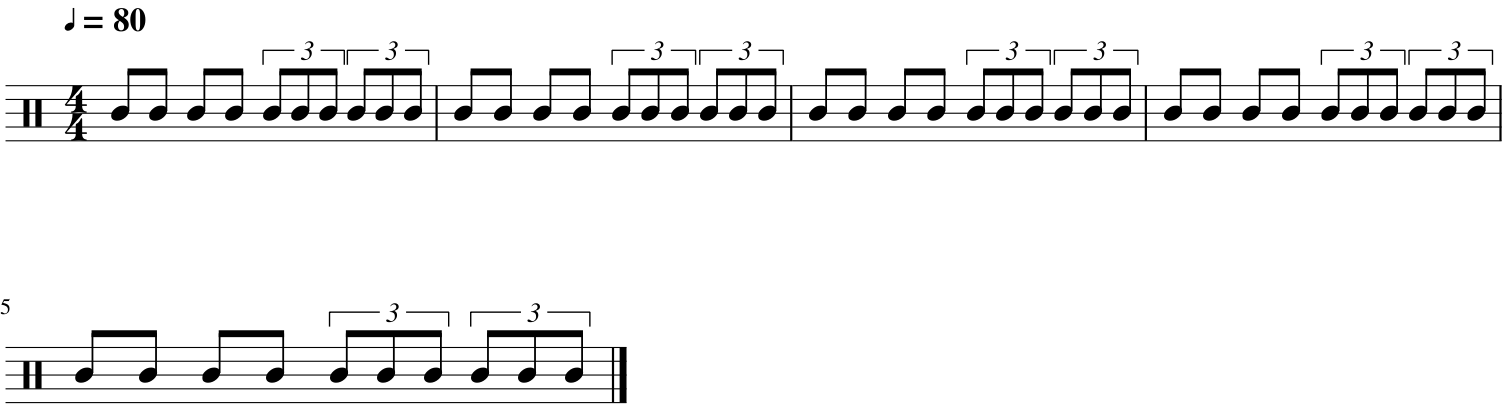

In [18]:
stream = create_percussive_stream(bpm=tempo, time_signature=time_signature)
for note in notes:
    stream.append(note)

play(stream)
show(stream)

# Seção de Experimentos
## Executando o pipeline completo para algumas músicas
- Para executar o pipeline completo, basta utilizar a função `transcription_pipeline`.
- A seguir podemos ver um exemplo dessa função para o início da Marcha Imperial.

Original:


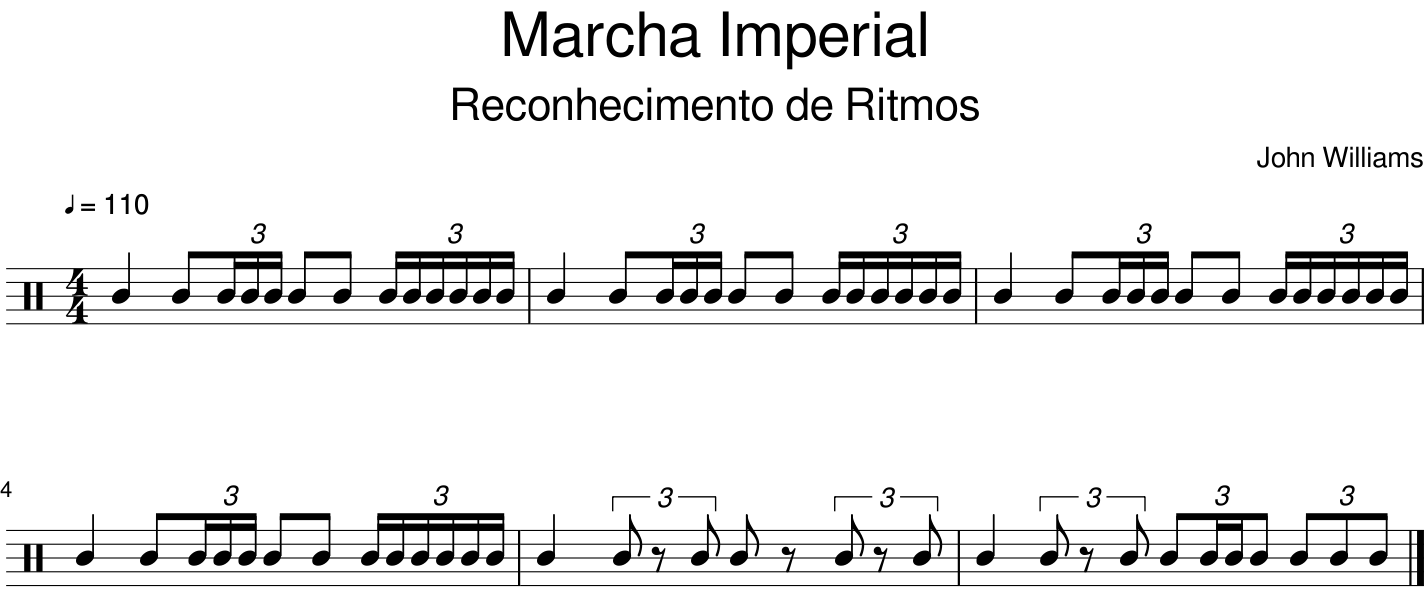

In [19]:
print('Original:')
music = 'musicas/marcha_imperial'
xml = f'data/xmls/{music}.musicxml'

play(parse(xml))
show(parse(xml))

Transcrito:


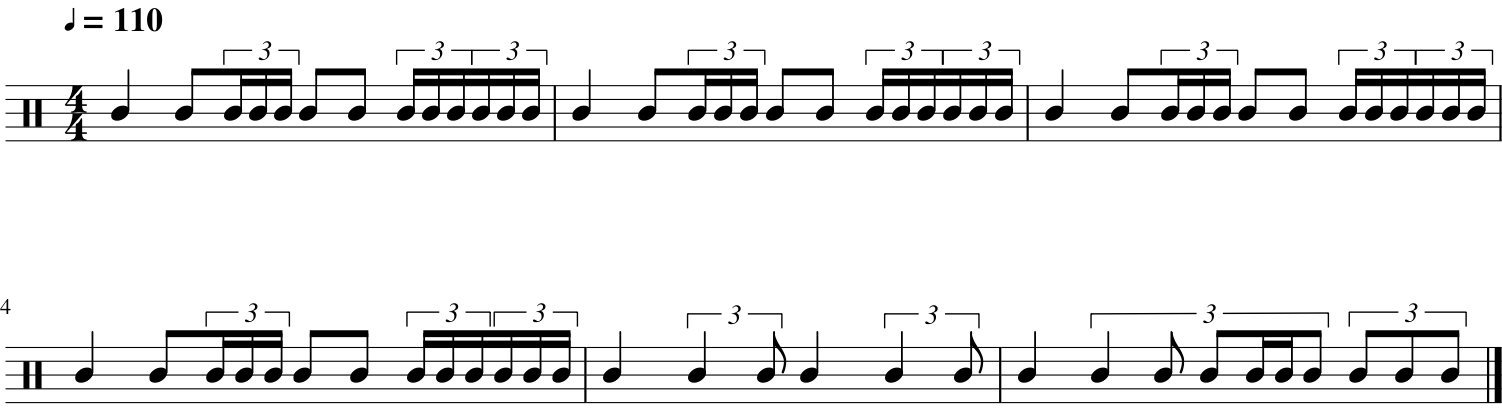

In [20]:
print('Transcrito:')
wavname = f'data/audios/{music}.wav'
stream = transcription_pipeline(wavname, time_signature='4/4')

play(stream)
show(stream)

In [21]:
!pip install beautifulsoup4 > /dev/null

In [68]:
from bs4 import BeautifulSoup

def are_bpm_equals(xml_1, xml_2):
  with open(xml_1) as f:
    sound = BeautifulSoup(f).find('sound')
    tempo1 = sound.attrs['tempo']

  with open(xml_2) as f:
    sound = BeautifulSoup(f).find('sound')
    tempo2 = sound.attrs['tempo']

  return tempo1 == tempo2

def isEquivalent(note1, note2):
  return note1.find('type').text == note2.find('type').text

def sheet_music_similarity(xml_1, xml_2):
  with open(xml_1) as f:
    notes1 = BeautifulSoup(f).findAll('note')
  with open(xml_2) as f:
    notes2 = BeautifulSoup(f).findAll('note')

  equals_notes = 0
  size = min(len(notes1), len(notes2))
  for i in range(size):
    if isEquivalent(notes1[i], notes2[i]):
      equals_notes += 1

  success = equals_notes / size
  return np.round(success, decimals=4)

In [23]:
with open('data/xmls/stick_control/colcheias_em_compasso_simples.musicxml') as f:
  sound = BeautifulSoup(f).find('sound')
  tempo = int(sound.attrs['tempo'])
  print(tempo)

80


In [24]:
with open('data/xmls/stick_control/padrao_simples_de_tercinas.musicxml') as f:
  sound = BeautifulSoup(f).find('sound')
  tempo = int(sound.attrs['tempo'])
  print(tempo)

80


In [25]:
xml1 = 'data/xmls/stick_control/colcheias_em_compasso_simples.musicxml'
xml2 = 'data/xmls/stick_control/padrao_simples_de_tercinas.musicxml'
are_bpm_equals(xml1, xml2)

True

In [34]:
with open('data/xmls/stick_control/colcheias_em_compasso_simples.musicxml') as f:
  note = BeautifulSoup(f).find('note')
  print(note.find('type').text)

eighth


In [43]:
from music21.musicxml import m21ToXml
def export_to_musicxml(stream, outname='music.musicxml'):
  GEX = m21ToXml.GeneralObjectExporter(stream)
  out = GEX.parse().decode('utf-8')
  with open(outname, 'w') as f:
    f.write(out)

In [74]:
# Exportando a marcha imperial
export_to_musicxml(stream, outname='teste.musicxml')

In [77]:
# Comparando XML original com o que foi gerado pela partitura que criamos
xml1 = 'data/xmls/musicas/marcha_imperial.musicxml'
xml2 = 'teste.musicxml'

percentual = sheet_music_similarity(xml1, xml2)
print('XMLs are', percentual, 'similar')

XMLs are 0.8529 similar
